In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import normaltest
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.svm import SVR
# from pyearth import Earth
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [ ]:
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

X = train.drop(columns = ['y','id'])
y = train['y']

test_ids = test['id']
test.drop(columns = 'id',inplace = True)

X = X.astype(float)
y = y.astype(float)
test = test.astype(float)

y = np.log(y)

counts = pd.DataFrame(X.nunique()).reset_index()
todrop = counts[counts[0] == 1]['index']

X.drop(columns = todrop,inplace = True)
test.drop(columns = todrop, inplace = True)


cols = X.columns


In [ ]:
corrs.iloc[0,0]

1.0

In [ ]:
corrs = pd.DataFrame(np.triu(X.corr()))
corrs.columns = cols
corrs.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,1.0,-0.102542,0.153749,0.379679,0.493197,0.247154,-0.165646,-0.103770,-0.032586,-0.108841,...,-0.010912,-0.052222,-0.006532,-0.016382,-0.057818,0.602138,-0.058439,0.629004,-0.149572,-0.005274
1,0.0,1.000000,-0.177286,0.035330,-0.180123,0.071401,0.463602,0.961286,0.103345,0.257011,...,-0.016834,0.058053,0.104158,0.045745,0.102208,-0.007468,0.101158,0.017972,0.819495,-0.022161
2,0.0,0.000000,1.000000,-0.066532,-0.052850,-0.113437,-0.500092,-0.197902,-0.179138,-0.323675,...,0.088638,-0.252394,-0.137534,-0.091690,-0.234049,0.159373,-0.236631,0.204255,-0.500867,-0.005638
3,0.0,0.000000,0.000000,1.000000,0.231413,0.222151,0.126973,0.075906,0.038667,0.097453,...,-0.018045,0.082101,0.021076,0.011411,0.044423,0.186038,0.046296,0.225874,0.086455,0.005585
4,0.0,0.000000,0.000000,0.000000,1.000000,0.166817,-0.061912,-0.115242,0.069205,-0.077010,...,-0.004641,0.050146,0.131325,0.046695,0.040076,-0.007635,0.042812,-0.128443,-0.025749,0.060317


In [ ]:
len(test.columns)

360

In [ ]:
bad_cols = []

for i in range(corrs.shape[1]):
    for j in range(corrs.shape[0]):
        if (corrs.iloc[j,i] > 0.95):
            if (i != j):
                bad_cols.append(i)

In [ ]:
to_drop_for_corr = list(np.unique(np.array(bad_cols)))
X.drop(X.columns[to_drop_for_corr],axis = 1, inplace = True)
test.drop(test.columns[to_drop_for_corr],axis = 1, inplace = True)

In [ ]:
X.shape

(5380, 360)

In [ ]:

#sc = StandardScaler()
#sc.fit(X)
#X = pd.DataFrame(sc.transform(X))
#test = pd.DataFrame(sc.transform(test))

Xknn = KNNImputer(n_neighbors=7)
Xknn.fit(X)
X = pd.DataFrame(Xknn.transform(X))
test = pd.DataFrame(Xknn.transform(test))

In [ ]:
#DO IT DIRECTLY FROM THE CORRELATION GRID
#TAKE THE UPPER TRIANGLE
#REMOVE ANYTHING WITH >0.95 CORR WITH ANYTHING


#

In [ ]:
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

In [ ]:
vif_keep = list(vif_data[(vif_data['VIF']<3) & (vif_data['feature'] != 'const')]['feature'])

X = X[vif_keep]
test = test[vif_keep]

In [ ]:
param_grid = {'max_depth': [4,6,8,10],
    'learning_rate': [0.05,0.1,0.5],
    'reg_lambda':[4,6,8],
    'n_estimators':[900,1000,1300,1500],
    'gamma':[0.1,1,10],
    'scale_pos_weight':[1,2,3],
    'subsample':[0.75,0.85,1]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                                    n_iter = 25,
                                    param_distributions =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 2,n_jobs=-1,cv=5)

optimal_params.fit(X,y)
optimal_params.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
catmodel = CatBoostRegressor().fit(X,y)
xgbmodel = xgb.XGBRegressor().fit(X,y)

preds = catmodel.predict(test)#*0.7 + xgbmodel.predict(test)*0.3

Learning rate set to 0.053413
0:	learn: 0.9828110	total: 55.2ms	remaining: 55.2s
1:	learn: 0.9673351	total: 97.5ms	remaining: 48.7s
2:	learn: 0.9544161	total: 138ms	remaining: 45.9s
3:	learn: 0.9410056	total: 178ms	remaining: 44.3s
4:	learn: 0.9290743	total: 218ms	remaining: 43.3s
5:	learn: 0.9182426	total: 258ms	remaining: 42.7s
6:	learn: 0.9081503	total: 297ms	remaining: 42.1s
7:	learn: 0.8975421	total: 337ms	remaining: 41.8s
8:	learn: 0.8877446	total: 377ms	remaining: 41.6s
9:	learn: 0.8794182	total: 417ms	remaining: 41.3s
10:	learn: 0.8715858	total: 456ms	remaining: 41s
11:	learn: 0.8638861	total: 497ms	remaining: 40.9s
12:	learn: 0.8567206	total: 536ms	remaining: 40.7s
13:	learn: 0.8494408	total: 574ms	remaining: 40.4s
14:	learn: 0.8429764	total: 609ms	remaining: 40s
15:	learn: 0.8366820	total: 645ms	remaining: 39.7s
16:	learn: 0.8308314	total: 683ms	remaining: 39.5s
17:	learn: 0.8250891	total: 721ms	remaining: 39.3s
18:	learn: 0.8193865	total: 760ms	remaining: 39.2s
19:	learn: 0.

163:	learn: 0.6335125	total: 6.72s	remaining: 34.3s
164:	learn: 0.6326432	total: 6.76s	remaining: 34.2s
165:	learn: 0.6322424	total: 6.8s	remaining: 34.2s
166:	learn: 0.6318645	total: 6.84s	remaining: 34.1s
167:	learn: 0.6314218	total: 6.88s	remaining: 34.1s
168:	learn: 0.6307692	total: 6.92s	remaining: 34s
169:	learn: 0.6302689	total: 6.95s	remaining: 33.9s
170:	learn: 0.6293978	total: 6.99s	remaining: 33.9s
171:	learn: 0.6286200	total: 7.03s	remaining: 33.8s
172:	learn: 0.6276536	total: 7.07s	remaining: 33.8s
173:	learn: 0.6266188	total: 7.11s	remaining: 33.8s
174:	learn: 0.6259085	total: 7.15s	remaining: 33.7s
175:	learn: 0.6252283	total: 7.19s	remaining: 33.7s
176:	learn: 0.6245253	total: 7.24s	remaining: 33.6s
177:	learn: 0.6238745	total: 7.28s	remaining: 33.6s
178:	learn: 0.6231758	total: 7.32s	remaining: 33.6s
179:	learn: 0.6225404	total: 7.36s	remaining: 33.5s
180:	learn: 0.6218997	total: 7.4s	remaining: 33.5s
181:	learn: 0.6209128	total: 7.44s	remaining: 33.4s
182:	learn: 0.61

326:	learn: 0.5345123	total: 13.1s	remaining: 26.9s
327:	learn: 0.5338967	total: 13.1s	remaining: 26.8s
328:	learn: 0.5332711	total: 13.1s	remaining: 26.8s
329:	learn: 0.5327951	total: 13.2s	remaining: 26.8s
330:	learn: 0.5323642	total: 13.2s	remaining: 26.7s
331:	learn: 0.5318252	total: 13.3s	remaining: 26.7s
332:	learn: 0.5313273	total: 13.3s	remaining: 26.6s
333:	learn: 0.5306706	total: 13.3s	remaining: 26.6s
334:	learn: 0.5301409	total: 13.4s	remaining: 26.5s
335:	learn: 0.5295849	total: 13.4s	remaining: 26.5s
336:	learn: 0.5288811	total: 13.4s	remaining: 26.5s
337:	learn: 0.5283682	total: 13.5s	remaining: 26.4s
338:	learn: 0.5277951	total: 13.5s	remaining: 26.4s
339:	learn: 0.5273135	total: 13.6s	remaining: 26.3s
340:	learn: 0.5267710	total: 13.6s	remaining: 26.3s
341:	learn: 0.5259722	total: 13.6s	remaining: 26.2s
342:	learn: 0.5256043	total: 13.7s	remaining: 26.2s
343:	learn: 0.5251186	total: 13.7s	remaining: 26.2s
344:	learn: 0.5245589	total: 13.8s	remaining: 26.1s
345:	learn: 

485:	learn: 0.4612959	total: 19.3s	remaining: 20.4s
486:	learn: 0.4607078	total: 19.3s	remaining: 20.3s
487:	learn: 0.4602187	total: 19.3s	remaining: 20.3s
488:	learn: 0.4598782	total: 19.4s	remaining: 20.2s
489:	learn: 0.4591514	total: 19.4s	remaining: 20.2s
490:	learn: 0.4586435	total: 19.5s	remaining: 20.2s
491:	learn: 0.4580390	total: 19.5s	remaining: 20.1s
492:	learn: 0.4576218	total: 19.5s	remaining: 20.1s
493:	learn: 0.4569451	total: 19.6s	remaining: 20s
494:	learn: 0.4563609	total: 19.6s	remaining: 20s
495:	learn: 0.4559860	total: 19.6s	remaining: 20s
496:	learn: 0.4557701	total: 19.7s	remaining: 19.9s
497:	learn: 0.4553133	total: 19.7s	remaining: 19.9s
498:	learn: 0.4550218	total: 19.8s	remaining: 19.8s
499:	learn: 0.4547076	total: 19.8s	remaining: 19.8s
500:	learn: 0.4543841	total: 19.8s	remaining: 19.8s
501:	learn: 0.4540715	total: 19.9s	remaining: 19.7s
502:	learn: 0.4535568	total: 19.9s	remaining: 19.7s
503:	learn: 0.4531059	total: 20s	remaining: 19.6s
504:	learn: 0.452528

649:	learn: 0.3993866	total: 25.8s	remaining: 13.9s
650:	learn: 0.3989636	total: 25.8s	remaining: 13.9s
651:	learn: 0.3987622	total: 25.9s	remaining: 13.8s
652:	learn: 0.3985088	total: 25.9s	remaining: 13.8s
653:	learn: 0.3979865	total: 25.9s	remaining: 13.7s
654:	learn: 0.3976434	total: 26s	remaining: 13.7s
655:	learn: 0.3974694	total: 26s	remaining: 13.7s
656:	learn: 0.3971936	total: 26.1s	remaining: 13.6s
657:	learn: 0.3966778	total: 26.1s	remaining: 13.6s
658:	learn: 0.3963100	total: 26.2s	remaining: 13.5s
659:	learn: 0.3961138	total: 26.2s	remaining: 13.5s
660:	learn: 0.3956603	total: 26.2s	remaining: 13.5s
661:	learn: 0.3956382	total: 26.3s	remaining: 13.4s
662:	learn: 0.3953022	total: 26.3s	remaining: 13.4s
663:	learn: 0.3948469	total: 26.4s	remaining: 13.3s
664:	learn: 0.3946018	total: 26.4s	remaining: 13.3s
665:	learn: 0.3941282	total: 26.4s	remaining: 13.3s
666:	learn: 0.3937966	total: 26.5s	remaining: 13.2s
667:	learn: 0.3935359	total: 26.5s	remaining: 13.2s
668:	learn: 0.39

813:	learn: 0.3474745	total: 32.3s	remaining: 7.38s
814:	learn: 0.3471843	total: 32.3s	remaining: 7.34s
815:	learn: 0.3468805	total: 32.4s	remaining: 7.3s
816:	learn: 0.3465602	total: 32.4s	remaining: 7.26s
817:	learn: 0.3462778	total: 32.5s	remaining: 7.22s
818:	learn: 0.3458729	total: 32.5s	remaining: 7.18s
819:	learn: 0.3455778	total: 32.5s	remaining: 7.14s
820:	learn: 0.3453192	total: 32.6s	remaining: 7.1s
821:	learn: 0.3449144	total: 32.6s	remaining: 7.06s
822:	learn: 0.3446480	total: 32.7s	remaining: 7.02s
823:	learn: 0.3444334	total: 32.7s	remaining: 6.98s
824:	learn: 0.3441983	total: 32.7s	remaining: 6.94s
825:	learn: 0.3438809	total: 32.8s	remaining: 6.9s
826:	learn: 0.3435759	total: 32.8s	remaining: 6.86s
827:	learn: 0.3433085	total: 32.9s	remaining: 6.82s
828:	learn: 0.3430019	total: 32.9s	remaining: 6.78s
829:	learn: 0.3425102	total: 32.9s	remaining: 6.75s
830:	learn: 0.3422735	total: 33s	remaining: 6.71s
831:	learn: 0.3418729	total: 33s	remaining: 6.67s
832:	learn: 0.34143

976:	learn: 0.3027382	total: 38.7s	remaining: 910ms
977:	learn: 0.3024422	total: 38.7s	remaining: 871ms
978:	learn: 0.3022866	total: 38.7s	remaining: 831ms
979:	learn: 0.3021125	total: 38.8s	remaining: 791ms
980:	learn: 0.3019113	total: 38.8s	remaining: 752ms
981:	learn: 0.3015381	total: 38.8s	remaining: 712ms
982:	learn: 0.3013307	total: 38.9s	remaining: 673ms
983:	learn: 0.3010654	total: 38.9s	remaining: 633ms
984:	learn: 0.3008513	total: 39s	remaining: 593ms
985:	learn: 0.3005758	total: 39s	remaining: 554ms
986:	learn: 0.3001999	total: 39s	remaining: 514ms
987:	learn: 0.2998211	total: 39.1s	remaining: 474ms
988:	learn: 0.2996109	total: 39.1s	remaining: 435ms
989:	learn: 0.2993550	total: 39.1s	remaining: 395ms
990:	learn: 0.2990165	total: 39.2s	remaining: 356ms
991:	learn: 0.2988283	total: 39.2s	remaining: 316ms
992:	learn: 0.2986141	total: 39.3s	remaining: 277ms
993:	learn: 0.2984305	total: 39.3s	remaining: 237ms
994:	learn: 0.2982806	total: 39.3s	remaining: 198ms
995:	learn: 0.2980

In [ ]:
preds = np.exp(preds)

In [ ]:
catmodel.predict(test)

In [ ]:
catmodel = CatBoostRegressor(random_state=0).fit(X,y)
xgbmodel = xgb.XGBRegressor(random_state=0).fit(X,y)

cat_preds = catmodel.predict(test)#
xgb_preds = xgbmodel.predict(test)

Learning rate set to 0.053413
0:	learn: 0.9828110	total: 26ms	remaining: 26s
1:	learn: 0.9673351	total: 38.4ms	remaining: 19.1s
2:	learn: 0.9544161	total: 51.5ms	remaining: 17.1s
3:	learn: 0.9410056	total: 63.4ms	remaining: 15.8s
4:	learn: 0.9290743	total: 75.2ms	remaining: 15s
5:	learn: 0.9182426	total: 87.1ms	remaining: 14.4s
6:	learn: 0.9081503	total: 98.9ms	remaining: 14s
7:	learn: 0.8975421	total: 111ms	remaining: 13.7s
8:	learn: 0.8877446	total: 123ms	remaining: 13.5s
9:	learn: 0.8794182	total: 136ms	remaining: 13.5s
10:	learn: 0.8715858	total: 148ms	remaining: 13.3s
11:	learn: 0.8638861	total: 161ms	remaining: 13.2s
12:	learn: 0.8567206	total: 173ms	remaining: 13.1s
13:	learn: 0.8494408	total: 184ms	remaining: 13s
14:	learn: 0.8429764	total: 197ms	remaining: 13s
15:	learn: 0.8366820	total: 211ms	remaining: 13s
16:	learn: 0.8308314	total: 226ms	remaining: 13s
17:	learn: 0.8250891	total: 240ms	remaining: 13.1s
18:	learn: 0.8193865	total: 254ms	remaining: 13.1s
19:	learn: 0.8138668

167:	learn: 0.6314218	total: 2.21s	remaining: 11s
168:	learn: 0.6307692	total: 2.23s	remaining: 10.9s
169:	learn: 0.6302689	total: 2.24s	remaining: 10.9s
170:	learn: 0.6293978	total: 2.25s	remaining: 10.9s
171:	learn: 0.6286200	total: 2.27s	remaining: 10.9s
172:	learn: 0.6276536	total: 2.28s	remaining: 10.9s
173:	learn: 0.6266188	total: 2.29s	remaining: 10.9s
174:	learn: 0.6259085	total: 2.31s	remaining: 10.9s
175:	learn: 0.6252283	total: 2.32s	remaining: 10.9s
176:	learn: 0.6245253	total: 2.33s	remaining: 10.8s
177:	learn: 0.6238745	total: 2.35s	remaining: 10.8s
178:	learn: 0.6231758	total: 2.36s	remaining: 10.8s
179:	learn: 0.6225404	total: 2.37s	remaining: 10.8s
180:	learn: 0.6218997	total: 2.38s	remaining: 10.8s
181:	learn: 0.6209128	total: 2.4s	remaining: 10.8s
182:	learn: 0.6199568	total: 2.41s	remaining: 10.8s
183:	learn: 0.6188553	total: 2.42s	remaining: 10.8s
184:	learn: 0.6184337	total: 2.44s	remaining: 10.7s
185:	learn: 0.6175404	total: 2.45s	remaining: 10.7s
186:	learn: 0.6

326:	learn: 0.5345123	total: 4.24s	remaining: 8.72s
327:	learn: 0.5338967	total: 4.25s	remaining: 8.7s
328:	learn: 0.5332711	total: 4.26s	remaining: 8.69s
329:	learn: 0.5327951	total: 4.27s	remaining: 8.68s
330:	learn: 0.5323642	total: 4.29s	remaining: 8.66s
331:	learn: 0.5318252	total: 4.3s	remaining: 8.65s
332:	learn: 0.5313273	total: 4.31s	remaining: 8.63s
333:	learn: 0.5306706	total: 4.32s	remaining: 8.62s
334:	learn: 0.5301409	total: 4.33s	remaining: 8.6s
335:	learn: 0.5295849	total: 4.34s	remaining: 8.59s
336:	learn: 0.5288811	total: 4.36s	remaining: 8.57s
337:	learn: 0.5283682	total: 4.37s	remaining: 8.56s
338:	learn: 0.5277951	total: 4.38s	remaining: 8.54s
339:	learn: 0.5273135	total: 4.39s	remaining: 8.53s
340:	learn: 0.5267710	total: 4.41s	remaining: 8.51s
341:	learn: 0.5259722	total: 4.42s	remaining: 8.5s
342:	learn: 0.5256043	total: 4.43s	remaining: 8.49s
343:	learn: 0.5251186	total: 4.44s	remaining: 8.47s
344:	learn: 0.5245589	total: 4.46s	remaining: 8.46s
345:	learn: 0.52

496:	learn: 0.4557701	total: 6.27s	remaining: 6.35s
497:	learn: 0.4553133	total: 6.29s	remaining: 6.34s
498:	learn: 0.4550218	total: 6.3s	remaining: 6.32s
499:	learn: 0.4547076	total: 6.31s	remaining: 6.31s
500:	learn: 0.4543841	total: 6.32s	remaining: 6.3s
501:	learn: 0.4540715	total: 6.33s	remaining: 6.28s
502:	learn: 0.4535568	total: 6.35s	remaining: 6.27s
503:	learn: 0.4531059	total: 6.36s	remaining: 6.26s
504:	learn: 0.4525280	total: 6.37s	remaining: 6.24s
505:	learn: 0.4519781	total: 6.38s	remaining: 6.23s
506:	learn: 0.4515894	total: 6.39s	remaining: 6.22s
507:	learn: 0.4512374	total: 6.41s	remaining: 6.21s
508:	learn: 0.4508807	total: 6.42s	remaining: 6.19s
509:	learn: 0.4505693	total: 6.43s	remaining: 6.18s
510:	learn: 0.4501722	total: 6.44s	remaining: 6.17s
511:	learn: 0.4499111	total: 6.46s	remaining: 6.15s
512:	learn: 0.4495859	total: 6.47s	remaining: 6.14s
513:	learn: 0.4495360	total: 6.48s	remaining: 6.13s
514:	learn: 0.4489816	total: 6.49s	remaining: 6.12s
515:	learn: 0.

655:	learn: 0.3974694	total: 8.34s	remaining: 4.38s
656:	learn: 0.3971936	total: 8.36s	remaining: 4.36s
657:	learn: 0.3966778	total: 8.37s	remaining: 4.35s
658:	learn: 0.3963100	total: 8.38s	remaining: 4.34s
659:	learn: 0.3961138	total: 8.4s	remaining: 4.33s
660:	learn: 0.3956603	total: 8.41s	remaining: 4.31s
661:	learn: 0.3956382	total: 8.43s	remaining: 4.3s
662:	learn: 0.3953022	total: 8.44s	remaining: 4.29s
663:	learn: 0.3948469	total: 8.45s	remaining: 4.28s
664:	learn: 0.3946018	total: 8.47s	remaining: 4.26s
665:	learn: 0.3941282	total: 8.48s	remaining: 4.25s
666:	learn: 0.3937966	total: 8.49s	remaining: 4.24s
667:	learn: 0.3935359	total: 8.5s	remaining: 4.23s
668:	learn: 0.3931572	total: 8.52s	remaining: 4.21s
669:	learn: 0.3926852	total: 8.53s	remaining: 4.2s
670:	learn: 0.3923265	total: 8.54s	remaining: 4.19s
671:	learn: 0.3920165	total: 8.56s	remaining: 4.18s
672:	learn: 0.3917523	total: 8.57s	remaining: 4.16s
673:	learn: 0.3917103	total: 8.58s	remaining: 4.15s
674:	learn: 0.39

825:	learn: 0.3438809	total: 10.6s	remaining: 2.23s
826:	learn: 0.3435759	total: 10.6s	remaining: 2.21s
827:	learn: 0.3433085	total: 10.6s	remaining: 2.2s
828:	learn: 0.3430019	total: 10.6s	remaining: 2.19s
829:	learn: 0.3425102	total: 10.6s	remaining: 2.17s
830:	learn: 0.3422735	total: 10.6s	remaining: 2.16s
831:	learn: 0.3418729	total: 10.6s	remaining: 2.15s
832:	learn: 0.3414387	total: 10.6s	remaining: 2.13s
833:	learn: 0.3410244	total: 10.7s	remaining: 2.12s
834:	learn: 0.3405962	total: 10.7s	remaining: 2.11s
835:	learn: 0.3403371	total: 10.7s	remaining: 2.1s
836:	learn: 0.3401688	total: 10.7s	remaining: 2.08s
837:	learn: 0.3399424	total: 10.7s	remaining: 2.07s
838:	learn: 0.3396672	total: 10.7s	remaining: 2.06s
839:	learn: 0.3393389	total: 10.7s	remaining: 2.04s
840:	learn: 0.3390140	total: 10.7s	remaining: 2.03s
841:	learn: 0.3387073	total: 10.8s	remaining: 2.02s
842:	learn: 0.3384467	total: 10.8s	remaining: 2s
843:	learn: 0.3381103	total: 10.8s	remaining: 1.99s
844:	learn: 0.337

998:	learn: 0.2973839	total: 12.8s	remaining: 12.8ms
999:	learn: 0.2970700	total: 12.8s	remaining: 0us


In [ ]:
preds = (0.8*np.exp(cat_preds)) + (0.2*np.exp(xgb_preds))
preds

array([4.23373506, 4.85855114, 3.02600377, ..., 8.16199076, 8.46644635,
       5.41973502])

In [ ]:
np.exp(xgb_preds)

array([3.7639537, 2.4558232, 3.0134706, ..., 9.623567 , 5.8650575,
       3.1287658], dtype=float32)

In [ ]:
predictions = pd.DataFrame({'id':test_ids,'y':preds})
predictions.head()

,id,y
0,5380,4.233735
1,5381,4.858551
2,5382,3.026004
3,5383,5.420678
4,5384,2.862394


In [ ]:


cat_pred_y = np.exp(catmodel.predict(test))#
xgb_pred_y = np.exp(xgbmodel.predict(test))
test_preds = 0.8*cat_pred_y + 0.2*xgb_pred_y

test_preds += 2.5

predictions = pd.DataFrame({'id':test_ids,'y':test_preds})

predictions.to_csv('catxgbintercept.csv',index=False) #:( 10.7

In [ ]:
cat_pred_y = np.exp(catmodel.predict(X))#
xgb_pred_y = np.exp(xgbmodel.predict(X))
test_pred_x = 0.8*cat_pred_y + 0.2*xgb_pred_y
test_pred_x

array([ 5.08375058,  1.53237226,  7.34604489, ..., 11.00704553,
       12.33411225, 25.5360077 ])

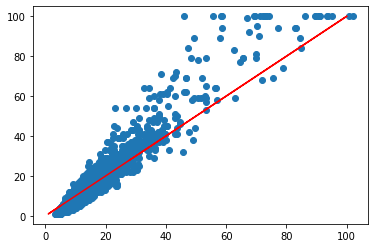

In [ ]:
plt.scatter(test_pred_x+2.5, np.exp(y))
plt.plot(np.exp(y), np.exp(y), c='red')

In [ ]:
param_grid = {'max_depth': [4,6,8],
    'n_estimators':[500, 600],
    'min_samples_split': [2, 4, 8],
    'max_features': [10, 20]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=RandomForestRegressor(random_state = 1),
                                    param_grid =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 4,n_jobs=-1,cv=5)

optimal_params.fit(X,y)
optimal_params.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


-0.777068487836247

In [ ]:
len(X.columns)

360

In [ ]:
optimal_params.best_estimator_

RandomForestRegressor(max_depth=8, max_features=20, min_samples_split=4,
                      n_estimators=600, random_state=1)

[CV 1/5] END max_depth=4, max_features=10, min_samples_split=2, n_estimators=500;, score=-0.837 total time=   6.2s
[CV 2/5] END max_depth=4, max_features=10, min_samples_split=4, n_estimators=600;, score=-0.847 total time=   8.5s
[CV 3/5] END max_depth=4, max_features=20, min_samples_split=2, n_estimators=600;, score=-0.793 total time=  18.2s
[CV 4/5] END max_depth=4, max_features=20, min_samples_split=8, n_estimators=600;, score=-0.821 total time=  22.4s
[CV 2/5] END max_depth=6, max_features=10, min_samples_split=4, n_estimators=600;, score=-0.824 total time=  18.4s
[CV 3/5] END max_depth=6, max_features=20, min_samples_split=2, n_estimators=500;, score=-0.767 total time=  26.2s
[CV 4/5] END max_depth=6, max_features=20, min_samples_split=4, n_estimators=600;, score=-0.794 total time=  31.5s
[CV 2/5] END max_depth=8, max_features=10, min_samples_split=2, n_estimators=600;, score=-0.812 total time=  22.0s
[CV 4/5] END max_depth=8, max_features=10, min_samples_split=8, n_estimators=500

[CV 3/5] END max_depth=4, max_features=10, min_samples_split=2, n_estimators=600;, score=-0.811 total time=   7.5s
[CV 1/5] END max_depth=4, max_features=20, min_samples_split=2, n_estimators=500;, score=-0.816 total time=  13.6s
[CV 2/5] END max_depth=4, max_features=20, min_samples_split=4, n_estimators=600;, score=-0.827 total time=  19.3s
[CV 3/5] END max_depth=6, max_features=10, min_samples_split=2, n_estimators=500;, score=-0.787 total time=  15.3s
[CV 4/5] END max_depth=6, max_features=10, min_samples_split=4, n_estimators=600;, score=-0.812 total time=  18.4s
[CV 5/5] END max_depth=6, max_features=20, min_samples_split=2, n_estimators=500;, score=-0.798 total time=  26.2s
[CV 1/5] END max_depth=6, max_features=20, min_samples_split=8, n_estimators=500;, score=-0.789 total time=  26.3s
[CV 3/5] END max_depth=8, max_features=10, min_samples_split=2, n_estimators=500;, score=-0.773 total time=  18.0s
[CV 4/5] END max_depth=8, max_features=10, min_samples_split=4, n_estimators=600

[CV 1/5] END max_depth=4, max_features=10, min_samples_split=4, n_estimators=500;, score=-0.837 total time=   6.3s
[CV 2/5] END max_depth=4, max_features=10, min_samples_split=8, n_estimators=500;, score=-0.847 total time=   7.0s
[CV 5/5] END max_depth=4, max_features=20, min_samples_split=2, n_estimators=500;, score=-0.826 total time=  14.8s
[CV 1/5] END max_depth=4, max_features=20, min_samples_split=8, n_estimators=500;, score=-0.816 total time=  17.3s
[CV 5/5] END max_depth=6, max_features=10, min_samples_split=2, n_estimators=500;, score=-0.819 total time=  16.0s
[CV 1/5] END max_depth=6, max_features=10, min_samples_split=8, n_estimators=500;, score=-0.810 total time=  14.6s
[CV 2/5] END max_depth=6, max_features=20, min_samples_split=2, n_estimators=600;, score=-0.803 total time=  31.5s
[CV 4/5] END max_depth=6, max_features=20, min_samples_split=8, n_estimators=500;, score=-0.793 total time=  25.8s
[CV 1/5] END max_depth=8, max_features=10, min_samples_split=4, n_estimators=500

In [ ]:
param_grid = {'max_depth': [8, 12, 16],
    'n_estimators':[400],
    'min_samples_split': [4, 5, 6],
    'max_features': [20, 30, 50]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=RandomForestRegressor(random_state = 1),
                                    param_grid =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 4,n_jobs=-1,cv=5)

optimal_params.fit(X,y)
print(optimal_params.best_estimator_)
print(optimal_params.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
RandomForestRegressor(max_depth=16, max_features=50, min_samples_split=6,
                      n_estimators=400, random_state=1)
-0.7515919183804451
[CV 4/5] END max_depth=8, max_features=20, min_samples_split=6, n_estimators=400;, score=-0.781 total time=  17.9s
[CV 2/5] END max_depth=8, max_features=30, min_samples_split=4, n_estimators=400;, score=-0.782 total time=  27.4s
[CV 3/5] END max_depth=8, max_features=50, min_samples_split=4, n_estimators=400;, score=-0.731 total time=  50.2s
[CV 4/5] END max_depth=12, max_features=20, min_samples_split=6, n_estimators=400;, score=-0.771 total time=  37.1s
[CV 2/5] END max_depth=12, max_features=30, min_samples_split=5, n_estimators=400;, score=-0.772 total time=  55.7s
[CV 3/5] END max_depth=12, max_features=50, min_samples_split=6, n_estimators=400;, score=-0.731 total time= 1.5min
[CV 3/5] END max_depth=16, max_features=20, min_samples_split=6, n_estimators=400;, score=-0.74

[CV 3/5] END max_depth=8, max_features=20, min_samples_split=4, n_estimators=400;, score=-0.752 total time=  18.0s
[CV 5/5] END max_depth=8, max_features=30, min_samples_split=5, n_estimators=400;, score=-0.777 total time=  27.5s
[CV 1/5] END max_depth=12, max_features=20, min_samples_split=4, n_estimators=400;, score=-0.768 total time=  27.2s
[CV 4/5] END max_depth=12, max_features=20, min_samples_split=4, n_estimators=400;, score=-0.772 total time=  33.5s
[CV 5/5] END max_depth=12, max_features=30, min_samples_split=4, n_estimators=400;, score=-0.769 total time=  54.8s
[CV 1/5] END max_depth=12, max_features=50, min_samples_split=5, n_estimators=400;, score=-0.754 total time= 1.6min
[CV 2/5] END max_depth=16, max_features=20, min_samples_split=5, n_estimators=400;, score=-0.780 total time=  41.5s
[CV 3/5] END max_depth=16, max_features=30, min_samples_split=5, n_estimators=400;, score=-0.735 total time= 1.0min
[CV 4/5] END max_depth=16, max_features=50, min_samples_split=5, n_estimat

In [ ]:
param_grid = {'max_depth': [None, 16, 20],
    'n_estimators':[400, 600, 800],
    'min_samples_split': [6, 7, 8],
    'max_features': ['sqrt', 'log2', None]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=RandomForestRegressor(random_state = 1),
                                    param_grid =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 4,n_jobs=-1,cv=5)

optimal_params.fit(X,y)
print(optimal_params.best_estimator_)
print(optimal_params.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_split=6, n_estimators=400;, score=-0.778 total time=  32.0s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=600;, score=-0.784 total time=  51.5s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_split=8, n_estimators=600;, score=-0.747 total time= 1.1min
[CV 2/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=600;, score=-0.805 total time=  27.4s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_split=7, n_estimators=400;, score=-0.764 total time=  18.2s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=400;, score=-0.764 total time=  19.6s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=800;, score=-0.786 total time=  45.5s
[CV 5/5] END max_depth=None, max_features=None, min_samples_split=6, n_estimators=800;, score=-0.7

[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=400;, score=-0.767 total time=  31.3s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=400;, score=-0.785 total time=  34.3s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=800;, score=-0.744 total time= 1.4min
[CV 3/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=600;, score=-0.763 total time=  27.6s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_split=7, n_estimators=400;, score=-0.788 total time=  18.2s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=400;, score=-0.788 total time=  19.8s
[CV 5/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=800;, score=-0.796 total time=  45.4s
[CV 1/5] END max_depth=None, max_features=None, min_samples_split=7, n_estimators=400;, score=-0.748 total time=10.4min
[CV 2/5] END max_depth=None, max_feature

[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_split=6, n_estimators=400;, score=-0.747 total time=  31.9s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=400;, score=-0.775 total time=  34.6s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_split=8, n_estimators=400;, score=-0.769 total time=  44.5s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_split=8, n_estimators=600;, score=-0.775 total time=  57.7s
[CV 5/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=800;, score=-0.794 total time=  37.9s
[CV 1/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=600;, score=-0.787 total time=  33.6s
[CV 2/5] END max_depth=None, max_features=None, min_samples_split=6, n_estimators=600;, score=-0.754 total time=104.0min
[CV 4/5] END max_depth=None, max_features=None, min_samples_split=7, n_estimators=600;, score=-0.750 total time=21.8min
[CV 5/5] END max_depth=None, max_featur

[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_split=6, n_estimators=600;, score=-0.770 total time=  49.1s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=600;, score=-0.744 total time= 1.1min
[CV 1/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=400;, score=-0.786 total time=  22.7s
[CV 5/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=400;, score=-0.794 total time=  18.1s
[CV 4/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=800;, score=-0.787 total time=  36.4s
[CV 1/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=400;, score=-0.787 total time=  18.9s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=600;, score=-0.765 total time=  34.7s
[CV 4/5] END max_depth=None, max_features=None, min_samples_split=6, n_estimators=600;, score=-0.751 total time=104.1min
[CV 5/5] END max_depth=None, max_featur

[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_split=6, n_estimators=400;, score=-0.768 total time=  31.9s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_split=7, n_estimators=600;, score=-0.767 total time=  51.6s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_split=8, n_estimators=600;, score=-0.783 total time= 1.1min
[CV 1/5] END max_depth=None, max_features=log2, min_samples_split=6, n_estimators=600;, score=-0.786 total time=  27.5s
[CV 2/5] END max_depth=None, max_features=log2, min_samples_split=7, n_estimators=400;, score=-0.802 total time=  18.0s
[CV 2/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=400;, score=-0.800 total time=  19.5s
[CV 3/5] END max_depth=None, max_features=log2, min_samples_split=8, n_estimators=800;, score=-0.764 total time=  45.7s
[CV 4/5] END max_depth=None, max_features=None, min_samples_split=6, n_estimators=800;, score=-0.750 total time=108.5min
[CV 5/5] END max_depth=None, max_featur

RandomForestRegressor(max_depth=20, max_features=None, min_samples_split=8,
                      n_estimators=800, random_state=1)
-0.7425854026192744


In [ ]:
predictions.to_csv('catxgb1.csv',index=False) #:( 10.7

In [ ]:
param_grid = {'max_depth': [8, 12, 16],
    'n_estimators':[600, 700, 800],
    'min_samples_split': [2, 4, 8],
    'max_features': [10, 20]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=RandomForestRegressor(random_state = 1),
                                    param_grid =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 4,n_jobs=-1,cv=5)

optimal_params.fit(X,y)
optimal_params.best_score_

## Random State Included - Everything That Worked From Start To Finish



In [ ]:
np.random.seed(0)
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

X = train.drop(columns = ['y','id'])
y = train['y']

test_ids = test['id']
test.drop(columns = 'id',inplace = True)

X = X.astype(float)
y = y.astype(float)
test = test.astype(float)

y = np.log(y)

counts = pd.DataFrame(X.nunique()).reset_index()
todrop = counts[counts[0] == 1]['index']

X.drop(columns = todrop,inplace = True)
test.drop(columns = todrop, inplace = True)


cols = X.columns


corrs = pd.DataFrame(np.triu(X.corr()))
corrs.columns = cols

bad_cols = []

# Dropping highly correlated columns
for i in range(corrs.shape[1]):
    for j in range(corrs.shape[0]):
        if (corrs.iloc[j,i] > 0.95):
            if (i != j):
                bad_cols.append(i)

to_drop_for_corr = list(np.unique(np.array(bad_cols)))
X.drop(X.columns[to_drop_for_corr],axis = 1, inplace = True)
test.drop(test.columns[to_drop_for_corr],axis = 1, inplace = True)


# Imputation
Xknn = KNNImputer(n_neighbors=7)
Xknn.fit(X)
X = pd.DataFrame(Xknn.transform(X))
test = pd.DataFrame(Xknn.transform(test))

In [ ]:
np.random.seed(0)

catmodel = CatBoostRegressor(random_state=0).fit(X,y)
xgbmodel = xgb.XGBRegressor(random_state=0).fit(X,y)

cat_preds = catmodel.predict(test)#
xgb_preds = xgbmodel.predict(test)


cat_pred_y = np.exp(catmodel.predict(test))#
xgb_pred_y = np.exp(xgbmodel.predict(test))
test_preds = 0.8*cat_pred_y + 0.2*xgb_pred_y

test_preds += 2.5

predictions = pd.DataFrame({'id':test_ids,'y':test_preds})

predictions.to_csv('catxgbintercept.csv',index=False) #:( 10.7

Learning rate set to 0.053413
0:	learn: 0.9828110	total: 125ms	remaining: 2m 5s
1:	learn: 0.9673351	total: 203ms	remaining: 1m 41s
2:	learn: 0.9544161	total: 292ms	remaining: 1m 37s
3:	learn: 0.9410056	total: 380ms	remaining: 1m 34s
4:	learn: 0.9290743	total: 457ms	remaining: 1m 30s
5:	learn: 0.9182426	total: 534ms	remaining: 1m 28s
6:	learn: 0.9081503	total: 607ms	remaining: 1m 26s
7:	learn: 0.8975421	total: 697ms	remaining: 1m 26s
8:	learn: 0.8877446	total: 769ms	remaining: 1m 24s
9:	learn: 0.8794182	total: 862ms	remaining: 1m 25s
10:	learn: 0.8715858	total: 941ms	remaining: 1m 24s
11:	learn: 0.8638861	total: 1.02s	remaining: 1m 24s
12:	learn: 0.8567206	total: 1.1s	remaining: 1m 23s
13:	learn: 0.8494408	total: 1.17s	remaining: 1m 22s
14:	learn: 0.8429764	total: 1.25s	remaining: 1m 21s
15:	learn: 0.8366820	total: 1.35s	remaining: 1m 23s
16:	learn: 0.8308314	total: 1.43s	remaining: 1m 22s
17:	learn: 0.8250891	total: 1.51s	remaining: 1m 22s
18:	learn: 0.8193865	total: 1.58s	remaining: 1

In [ ]:
X.isna().sum()

x001     10
x002      0
x003      3
x004      0
x005     10
       ... 
x761      0
x762     53
x763      0
x764      3
x765    375
Length: 754, dtype: int64

In [ ]:
predictions.head()

,id,y
0,5380,6.733735
1,5381,7.358551
2,5382,5.526004
3,5383,7.920678
4,5384,5.362394
